In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier # AdaBoost often uses this as a base estimator
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

In [2]:
# --- 配置 ---
file_path = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv'
# 特征列 - 同样排除 'rating'
text_col = 'review_content'
categorical_cols = ['game_name']
numerical_cols = ['likes']
feature_columns = [text_col] + categorical_cols + numerical_cols
target_column = 'sentiment'
test_size = 0.2
random_state = 42

In [3]:
# --- 1. 加载数据 ---
print(f"开始加载数据: {file_path}")
try:
    df = pd.read_csv(file_path)
    print(f"数据加载成功，总行数: {len(df)}")
    # 选择必要的列 + 目标列
    df = df[feature_columns + [target_column]].copy()

    # 基础缺失值处理
    df[text_col] = df[text_col].fillna('') # 填充缺失评论
    df[categorical_cols] = df[categorical_cols].fillna('Unknown') # 填充缺失类别
    # 数值列的 NaN 留给 SimpleImputer 处理
    df.dropna(subset=[target_column], inplace=True) # 删除目标缺失的行
    print(f"\n处理必要列的缺失值后，剩余行数: {len(df)}")

    # 确保目标列是整数
    df[target_column] = df[target_column].astype(int)

    print("\n数据信息 (选择的列):")
    df.info()
    print(f"\n目标变量 '{target_column}' 分布:")
    print(df[target_column].value_counts(normalize=True))

except FileNotFoundError:
    print(f"错误: 文件未找到 {file_path}")
    exit()
except Exception as e:
    print(f"加载或初步处理数据时发生错误: {e}")
    exit()

开始加载数据: D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv
数据加载成功，总行数: 39985

处理必要列的缺失值后，剩余行数: 39985

数据信息 (选择的列):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39985 entries, 0 to 39984
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_content  39985 non-null  object
 1   game_name       39985 non-null  object
 2   likes           39985 non-null  int64 
 3   sentiment       39985 non-null  int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 1.1+ MB

目标变量 'sentiment' 分布:
sentiment
1    0.659072
0    0.340928
Name: proportion, dtype: float64


In [4]:
# --- 2. 准备特征和目标 ---
X = df[feature_columns]
y = df[target_column]

In [5]:
# --- 3. 划分数据 ---
print(f"\n划分数据集，测试集比例: {test_size}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)
print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")


划分数据集，测试集比例: 0.2
训练集大小: 31988, 测试集大小: 7997


In [6]:
# --- 4. 创建预处理管道 ---
print("\n创建预处理管道...")
# 与 XGBoost 示例相同的预处理器
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words=None))
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # AdaBoost 通常处理密集数组更好
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ],
    remainder='passthrough'
)


创建预处理管道...


In [7]:
# --- 5. 定义 AdaBoost 分类器 ---
print("初始化 AdaBoostClassifier...")
# AdaBoostClassifier 默认使用 DecisionTreeClassifier(max_depth=1)
# 你可以显式指定或调整 base_estimator
base_estimator = DecisionTreeClassifier(max_depth=12, random_state=random_state)

# 注意：AdaBoostClassifier 没有 GPU 参数
ada_model = AdaBoostClassifier(
    estimator=base_estimator, # 可以省略，使用默认的 DecisionTreeClassifier(max_depth=1)
    n_estimators=200,        # 弱学习器的数量 (树的数量)
    learning_rate=0.5,       # 学习率 (默认值通常是 1.0)
    random_state=random_state
    # algorithm='SAMME.R' is default and usually preferred
)

初始化 AdaBoostClassifier...


In [8]:
# --- 6. 创建完整管道 (预处理器 + 分类器) ---
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', ada_model)])

In [9]:
# --- 7. 训练管道 ---
print("\n开始训练模型管道 (将在 CPU 上运行)...")
start_time = time.time()

# 直接拟合整个管道
pipeline.fit(X_train, y_train)
# AdaBoostClassifier 在 scikit-learn 中没有内置的 eval_set 或 early_stopping_rounds

end_time = time.time()
print(f"模型训练完成，耗时: {end_time - start_time:.2f} 秒")


开始训练模型管道 (将在 CPU 上运行)...


KeyboardInterrupt: 

In [ ]:
# --- 8. 在测试集上预测 ---
print("\n在测试集上进行预测...")
y_pred = pipeline.predict(X_test)


在测试集上进行预测...



模型评估:
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      2726
           1       0.80      0.87      0.83      5271

    accuracy                           0.77      7997
   macro avg       0.75      0.72      0.73      7997
weighted avg       0.76      0.77      0.76      7997


Confusion Matrix:
[[1573 1153]
 [ 689 4582]]


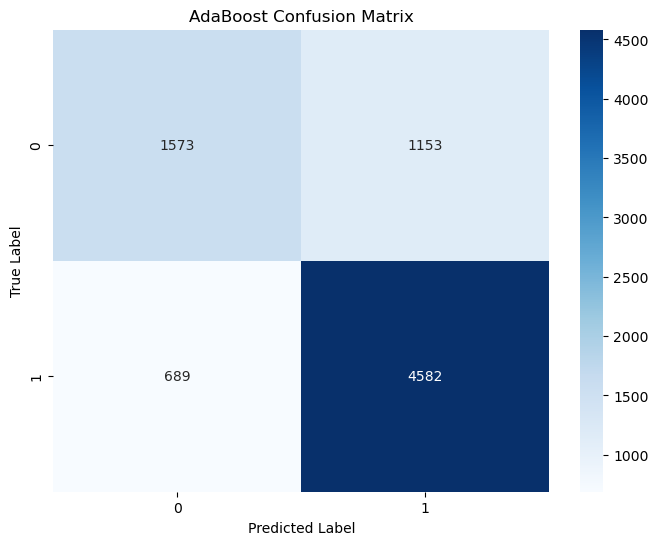


脚本执行完毕。


In [ ]:
# --- 9. 评估模型 ---
print("\n模型评估:")

# Classification Report
print("Classification Report:")
try:
    target_names = [str(c) for c in sorted(y.unique())]
    print(classification_report(y_test, y_pred, target_names=target_names))
except Exception as e:
    print(f"生成 classification report 时出错: {e}")
    print("Classification Report (无 target_names):")
    print(classification_report(y_test, y_pred))


# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AdaBoost Confusion Matrix')
plt.show()

print("\n脚本执行完毕。")